# Jump detection and classification example 1

This notebook shows the basic usage of the jump detection and classification routines using a Q3 light curve with one real discontinuity, several artificial jumps, and two transit-like signals.

In [1]:
%pylab inline
import seaborn as sb
sb.set_context('notebook')
sb.set_style('ticks')
rc('figure', figsize=(16,5))

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keplerjc import KData, JumpFinder, JumpClassifier, Jump, correct_jumps

data = load('test_data.npz')
cadence = data['cadence']
fluxes  = data['flux']
flux_o  = fluxes[1,:].copy()
flux    = fluxes[1,:].copy()

The light curve already contains one real jump near cadence 7915, but we'll add some additional ones, as well as a single large jump that we later ask to be ignored.

Let's also add two transit-like signals to the light curve for the fun of it: a deep one with a short duration, and a shallower one with a longer duration.

In [3]:
flux[cadence>8300]  *= 0.997
flux[cadence>9200]  *= 0.99
flux[cadence>9500]  *= 1.0025
flux[cadence>9900]  *= 1.0015
flux[cadence>11000] *= 1.0025

flux[(cadence>8600)&(cadence<8610)]  *= 0.995
flux[(cadence>11200)&(cadence<11215)]  *= 0.998

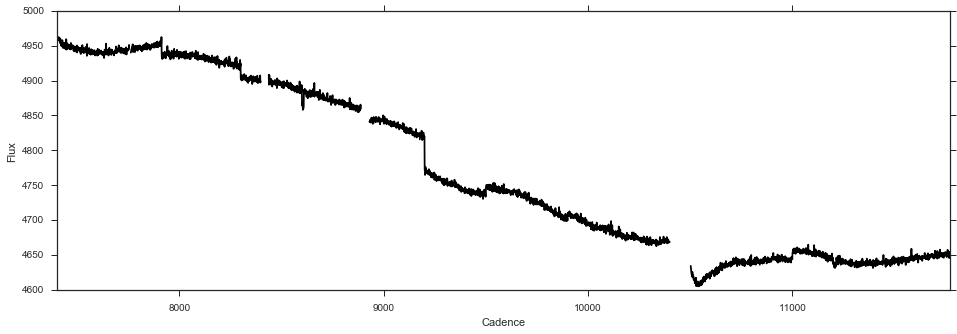

In [4]:
kdata = KData(cadence, flux)
kdata.plot()

## Jump detection

Jump detection is carried out with the `find_jumps` method of the `JumpFinder` class, and takes $\sim$15 seconds for a single long cadence light curve quarter. The method returns a list of `Jump` objects with `type = None`.

In [5]:
jf = JumpFinder(kdata, exclude=[[8883,8938], [10390,10520]])
%time jumps = jf.find_jumps()
print(jumps)

CPU times: user 19.6 s, sys: 39.2 s, total: 58.8 s
Wall time: 16.6 s
[Jump(7420.0, -0.0, None), Jump(7914.0, -0.0, None), Jump(8301.0, -0.0, None), Jump(8601.0, -0.0, None), Jump(9101.0, -0.0, None), Jump(9201.0, -0.0, None), Jump(9501.0,  0.0, None), Jump(9901.0,  0.0, None), Jump(9951.0, -0.0, None), Jump(11001.0,  0.0, None), Jump(11201.0, -0.0, None)]


## Jump classification

Jump classification is carried out with the `classify` method of the `JumpClassifier` class, and, in this example, takes $\sim$25 seconds. The method is given a list of jumps (or a single Jump object), and it sets the jump types to match the best matching type. *Note: the method modifies the given jump objects.* 

In [6]:
jc = JumpClassifier(kdata, jf.hp)
%time jc.classify(jumps)
print(jumps)

CPU times: user 1min 13s, sys: 2min 16s, total: 3min 29s
Wall time: 54.1 s
[Jump(7420.0, -0.0, jump), Jump(7914.0, -0.0, jump), Jump(8301.0, -0.0, jump), Jump(8601.0, -0.0, transit), Jump(9101.0, -0.0, jump), Jump(9201.0, -0.0, jump), Jump(9501.0,  0.0, jump), Jump(9901.0,  0.0, jump), Jump(9951.0, -0.0, noise), Jump(11001.0,  0.0, jump), Jump(11201.0, -0.0, transit)]


## Correct the discontinuities identified as jumps

Finally, we use the `correct_jumps` convenience function to obtain a new `KData` instance with the discontinuities identified as jumps removed.

In [7]:
cdata = correct_jumps(kdata, jumps)

Plot the detected discontinuities
---------------------------------

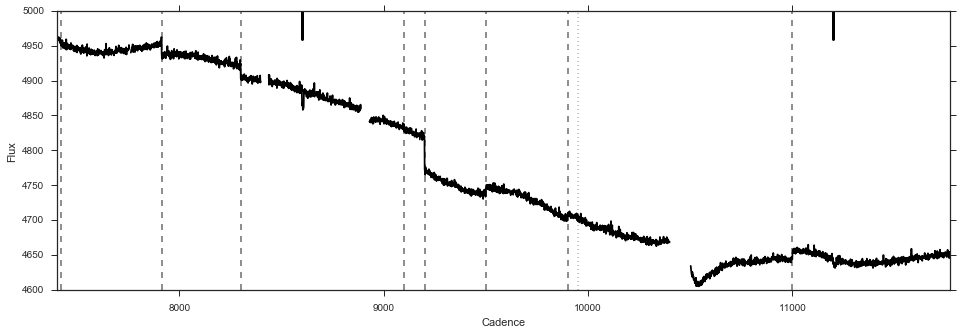

In [8]:
kdata.plot(jumps)

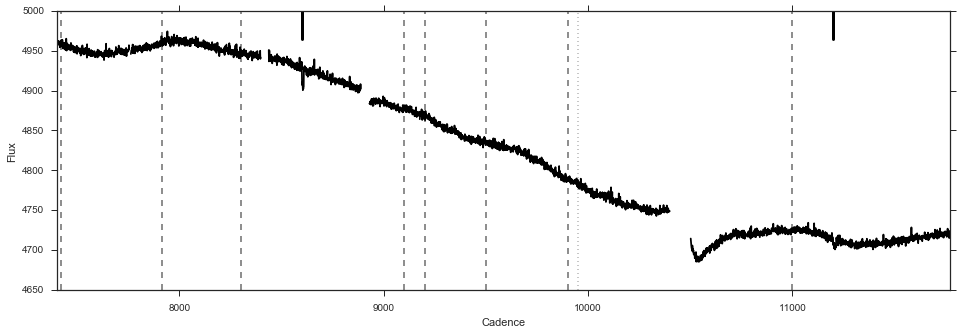

In [9]:
cdata.plot(jumps)

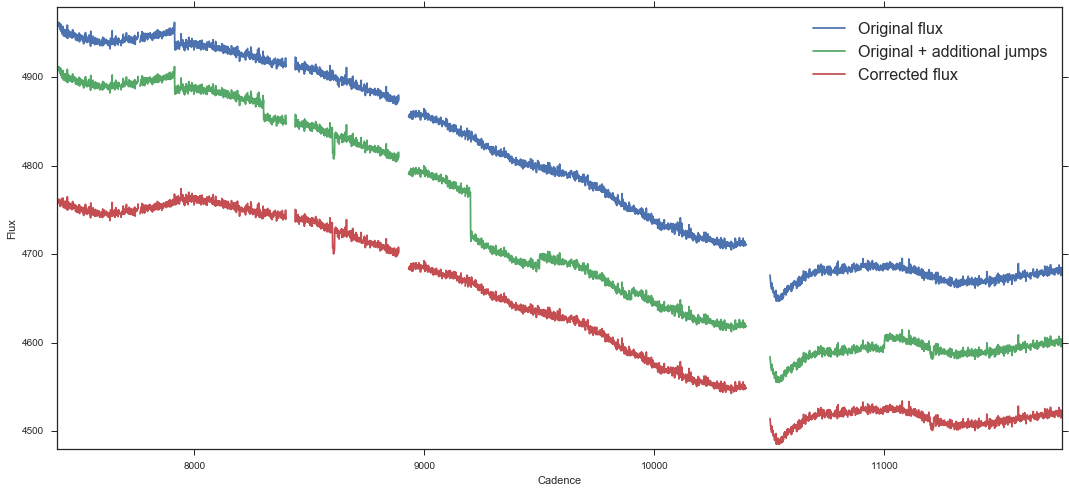

In [11]:
fig,ax = subplots(1,1,figsize=(15,7))
plot(cadence, flux_o, label='Original flux')
plot(kdata._cadence, kdata._flux - 50, label='Original + additional jumps')
plot(cdata._cadence, cdata._flux - 200, label='Corrected flux')
setp(ax, xlim=cadence[[0,-1]], ylim=(4480,4980), xlabel='Cadence', ylabel='Flux')
ax.legend(loc=1, fontsize=16)
fig.tight_layout()

----

<center> &copy; 2016 Hannu Parviainen </center>